## **Table of Contents of the notebook:**

1. <a href="#1">**Install**</a>
2. <a href="#2">**Reading the dataset**</a>
3. <a href="#3">**Data Preperation**</a>
4. <a href="#4">**Train Test Split**</a>
5. <a href="#5">**Gaining Insights (EDA)**</a>
6. <a href="#6">**Time Series Models**</a>
7. <a href="#7">**Machine Leaning Model**</a>
8. <a href="#8">**Choosing Best Model**</a>

---

# 1. <a name="1">**Install**</a>
(<a href="#0">Go to top</a>)

**Installing and Importing used libraries.**

In [3]:
# Install pmdarima
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.2 MB/s eta 0:00:0000:01


In [4]:
# Install statsmodels
!pip install git+https://github.com/statsmodels/statsmodels.git@74836e9cf2198ac7a930146405da7239c0823a9b#egg=statsmodels

  Cloning https://github.com/statsmodels/statsmodels.git (to revision 74836e9cf2198ac7a930146405da7239c0823a9b) to /tmp/pip-install-f889sk5z/statsmodels_0f80141e0b604f14ae0f3f5c66d8aa27
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels.git /tmp/pip-install-f889sk5z/statsmodels_0f80141e0b604f14ae0f3f5c66d8aa27
  Running command git rev-parse -q --verify 'sha^74836e9cf2198ac7a930146405da7239c0823a9b'
  Running command git fetch -q https://github.com/statsmodels/statsmodels.git 74836e9cf2198ac7a930146405da7239c0823a9b
  Running command git checkout -q 74836e9cf2198ac7a930146405da7239c0823a9b
  Resolved https://github.com/statsmodels/statsmodels.git to commit 74836e9cf2198ac7a930146405da7239c0823a9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev0+345.g74836e9cf-cp310-cp310-linux_x86_64.whl si

In [126]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
from plotly.subplots import make_subplots
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from prophet import Prophet
# logging.getLogger("cmdstanpy").disabled = True 
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from itertools import product

---

# 2. <a name="2">**Reading the dataset**</a>
(<a href="#0">Go to top</a>)

In [7]:
df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', index_col = "Date", low_memory=False, parse_dates=['Date'])

In [8]:
df.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


---

# 3. <a name="3">**Data preperation**</a>
(<a href="#0">Go to top</a>)

## A- Choose The Store We will work on (Store 1)

In [10]:
df = df[df["Store"] == 1]

## B- Check for nulls

In [11]:
df.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## C- Make freq as daily

In [12]:
df = df.asfreq('D')

In [13]:
df.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## D- Remove Customers column as it won't be available in production

In [14]:
df.drop(["Customers"], axis=1,inplace=True)

## E- Sort by date

In [15]:
df.sort_values(by="Date", inplace=True)

---

# 4. <a name="4">**Train Test Split**</a>
(<a href="#0">Go to top</a>)

### <font color='green'>**Split data into train and test 80:20**</font>

In [16]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

---

# 5. <a name="5">**Gaining Insights (EDA)**</a>
(<a href="#0">Go to top</a>)

## A- Plot Sales (All train data) 

In [17]:
fig = px.line(train_data, x=train_data.index if 'Day' not in train_data else 'Day', y='Sales', title='Sales over Time (Whole data)')
fig.update_layout(
    xaxis_title='Day',
    yaxis_title='Sales',
    width=1000,  # Width of the figure
    height=600,  # Height of the figure
)
fig.show()


## B- Plot Sales (One Month) 

In [18]:
subset_data = train_data[:30] if 'Day' not in train_data else train_data.iloc[:30]

fig = px.line(subset_data, x=subset_data.index if 'Day' not in subset_data else 'Day', y='Sales', title='Sales over Time (One Month)')
fig.update_layout(
    xaxis_title='Day',
    yaxis_title='Sales',
    width=1000,  # Width of the figure
    height=600,  # Height of the figure
)
fig.show()

### <font color='green'>**It seems that Friday is the off day of the stores**</font>

## C- Plot Sales (One Year) 

In [19]:
subset_data = train_data[:365] if 'Day' not in train_data else train_data.iloc[:365]

fig = px.line(subset_data, x=subset_data.index if 'Day' not in subset_data else 'Day', y='Sales', title='Sales over Time (One Year)')
fig.update_layout(
    xaxis_title='Day',
    yaxis_title='Sales',
    width=1000,  # Width of the figure
    height=600,  # Height of the figure
)
fig.show()

### <font color='green'>**We see a peak in sales in Dec**</font>

## D- Extract additional columns 

In [20]:
train_data['year'] = train_data.index.year
train_data['month'] = train_data.index.month
train_data['day'] = train_data.index.day

# Convert the columns to integers
train_data['year'] = train_data['year'].astype(int)
train_data['month'] = train_data['month'].astype(int)
train_data['day'] = train_data['day'].astype(int)

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          753 non-null    int64 
 1   DayOfWeek      753 non-null    int64 
 2   Sales          753 non-null    int64 
 3   Open           753 non-null    int64 
 4   Promo          753 non-null    int64 
 5   StateHoliday   753 non-null    object
 6   SchoolHoliday  753 non-null    int64 
 7   year           753 non-null    int64 
 8   month          753 non-null    int64 
 9   day            753 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 64.7+ KB


## E- Plot sales by different dates values

In [23]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Sales by Year', 'Sales by Month', 'Sales by Day', 'Sales by Weekday')
)

# Sales by Year
fig.add_trace(
    go.Bar(x=train_data['year'], y=train_data['Sales']),
    row=1, col=1
)

# Sales by Month
fig.add_trace(
    go.Bar(x=train_data['month'], y=train_data['Sales']),
    row=1, col=2
)

# Sales by Day
fig.add_trace(
    go.Bar(x=train_data['day'], y=train_data['Sales']),
    row=2, col=1
)

# Sales by Weekday
fig.add_trace(
    go.Bar(x=train_data['DayOfWeek'], y=train_data['Sales']),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800, width=1200,
    title_text="Sales Data Visualization",
    showlegend=False
)

# Show plot
fig.show()

### <font color='green'>**The Insighst we gained:**<Br><Br>1. Sales decrease over the years<Br><Br>2. The peak of sales is on Nov and Dec<Br><Br>3. Sales increase in the opening and closing day of the week</font>

## F- Define Monthly seasonal plot

In [25]:
def monthly_quarter_line_plot(df, col_x, col_y, hue_col, title="Monthly"):
    # Create a line plot using Plotly
    fig = px.line(df, x=col_x, y=col_y, color=hue_col, title=title + ' Seasonal plot', color_discrete_sequence=px.colors.qualitative.Tab10)
    
    # Update layout to move the legend outside of the main figure
    fig.update_layout(
        legend=dict(
            x=1.05,  # Adjust this value to move the legend
            y=1,
            traceorder='normal'
        ),
        margin=dict(l=0, r=200, t=50, b=0)  # Adjust margins to accommodate the legend
    )

    # Show the plot
    fig.show()

In [161]:
def monthly_quarter_line_plot(df, col_x, col_y, hue_col, title="Monthly"):
    # Create a line plot using Plotly
    fig = px.line(df, x=col_x, y=col_y, color=hue_col, title=title + ' Seasonal plot', color_discrete_sequence=plotly.colors.qualitative.T10)
    
    # Update layout to move the legend outside of the main figure
    fig.update_layout(
        legend=dict(
            x=1.05,  # Adjust this value to move the legend
            y=1,
            traceorder='normal'
        ),
        margin=dict(l=0, r=200, t=50, b=0)  # Adjust margins to accommodate the legend
    )

    # Show the plot
    fig.show()

## G- plot Monthly seasonal

In [27]:
monthly_quarter_line_plot(train_data, 'month', 'Sales', 'year', title="Monthly")

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## H- Plot Sales in different conditions

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define colors for each bar plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create subplots: 2 rows, 2 columns
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Sales in Open', 'Sales in Promo', 'Sales in StateHoliday', 'Sales in SchoolHoliday')
)

# Sales in Open
fig.add_trace(
    go.Bar(x=train_data['Open'], y=train_data['Sales'], marker_color=colors[0]),
    row=1, col=1
)

# Sales in Promo
fig.add_trace(
    go.Bar(x=train_data['Promo'], y=train_data['Sales'], marker_color=colors[1]),
    row=1, col=2
)

# Sales in StateHoliday
fig.add_trace(
    go.Bar(x=train_data['StateHoliday'], y=train_data['Sales'], marker_color=colors[2]),
    row=2, col=1
)

# Sales in SchoolHoliday
fig.add_trace(
    go.Bar(x=train_data['SchoolHoliday'], y=train_data['Sales'], marker_color=colors[3]),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800, width=1200,
    title_text="Sales Data Visualization",
    showlegend=False,
    margin=dict(t=100)
)

# Show plot
fig.show()


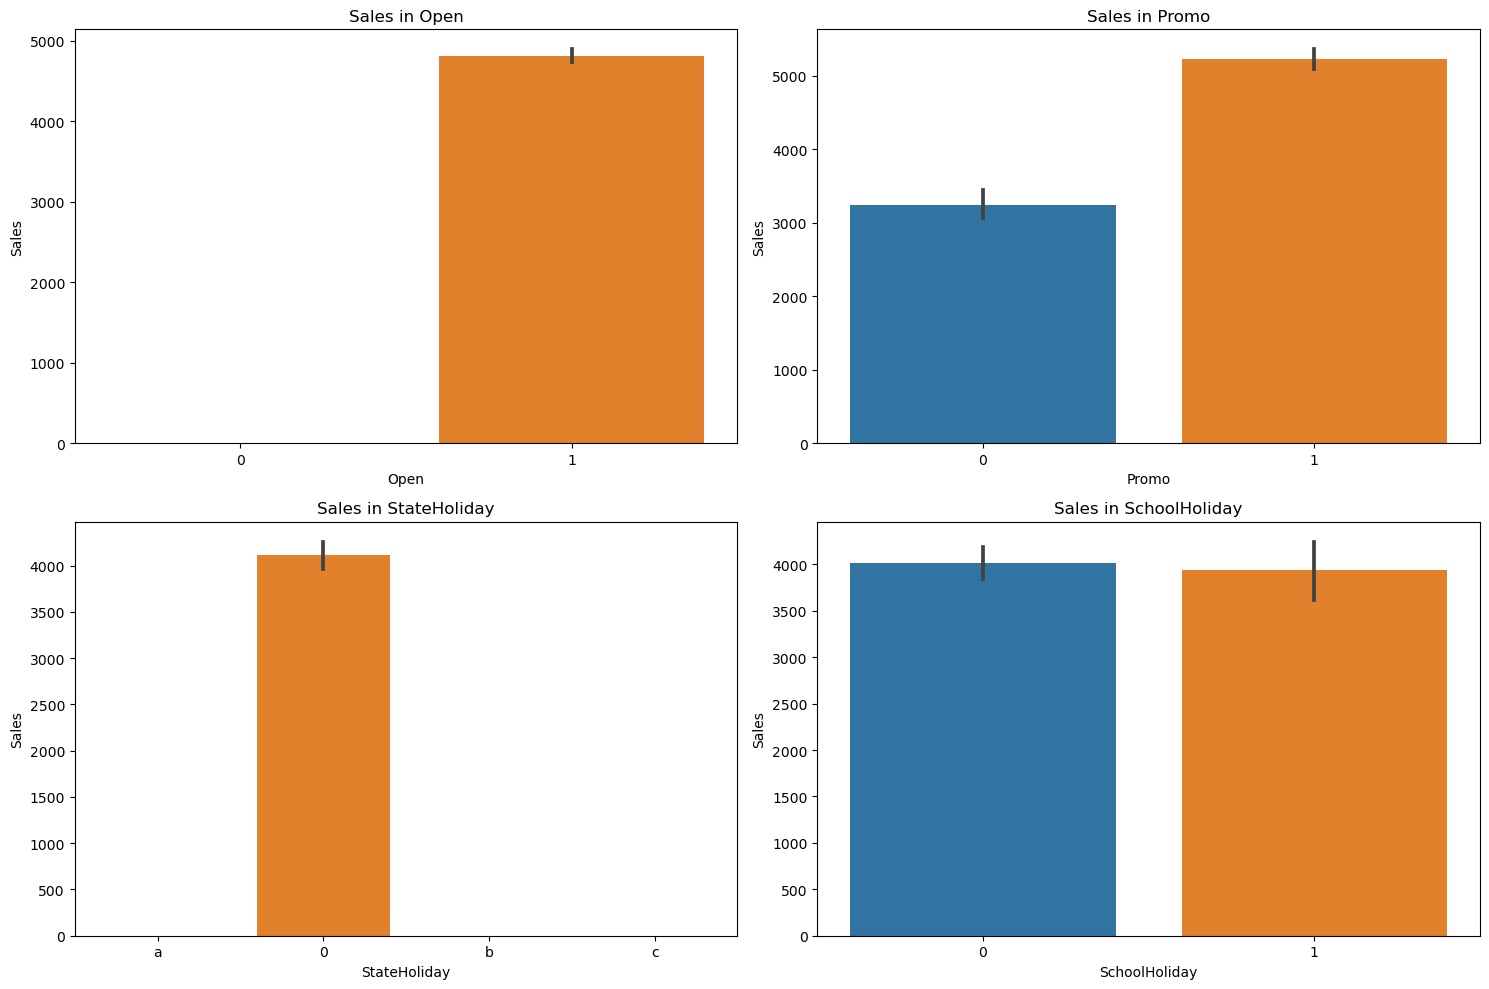

In [163]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='Open',y="Sales", data=train_data, ax=axes[0, 0])
sns.barplot(x='Promo',y="Sales", data=train_data, ax=axes[0, 1])
sns.barplot(x='StateHoliday',y="Sales", data=train_data, ax=axes[1, 0])
sns.barplot(x='SchoolHoliday',y="Sales", data=train_data, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales in Open')
axes[0, 1].set_title('Sales in Promo')
axes[1, 0].set_title('Sales in StateHoliday')
axes[1, 1].set_title('Sales in SchoolHoliday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

### <font color='green'>**Nothing unusual, no sales when store is closed, State holidays don't add new information, sales increase in promo, and Shool holidays don't make that difference**</font>

## I- Define histogram function

In [296]:
def histograms(df,col_name,bins_number=100,diff=False, xmin=-1000, xmax=1000):
    if diff:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name].diff(),bins=bins_number)
        plt.xlim(xmin,xmax)
        plt.show()
    else:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name],bins=bins_number)
        plt.show()

## J- Distribution of sales values differences (When the store is not closed)

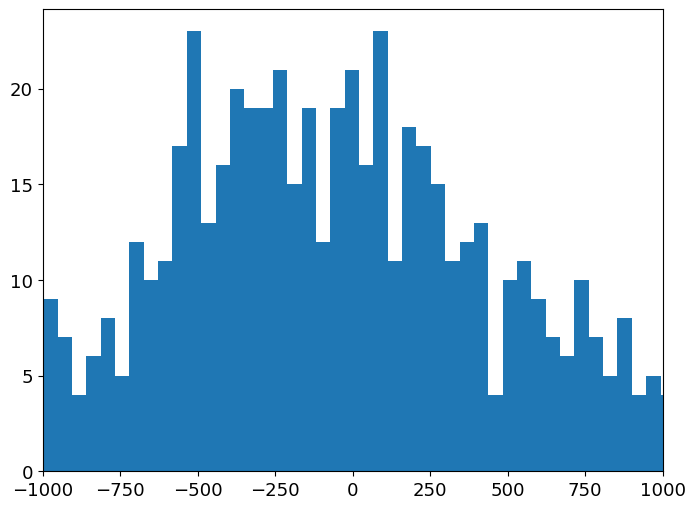

In [297]:
histograms(train_data[train_data["Sales"] != 0],"Sales",bins_number=200,diff=True)

## K- Distribution of sales values (When the store is not closed)

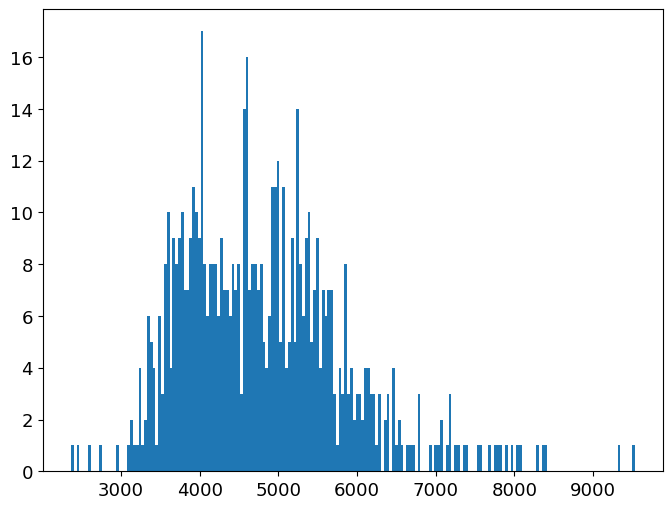

In [298]:
histograms(train_data[train_data["Sales"] != 0],"Sales",bins_number=200,diff=False)

---

# 6. <a name="6">**Time Series Models**</a>
(<a href="#0">Go to top</a>)

### Eval Metric (RMSPE):

In [41]:
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

### Plot train vs test

In [42]:
fig = go.Figure()

# Adding training data to the plot
fig.add_trace(go.Scatter(
    x=train_data.index, y=train_data["Sales"],
    mode='lines', name='Train', line=dict(color='blue')
))

# Adding test data to the plot
fig.add_trace(go.Scatter(
    x=test_data.index, y=test_data["Sales"],
    mode='lines', name='Test', line=dict(color='orange')
))

# Updating layout to match the specifications
fig.update_layout(
    height=600,
    width=1600,
    title='Sales Data',
    xaxis_title='Index',
    yaxis_title='Sales'
)

fig.show()

## **A- Simple Forecasting Models**

### Models Functions

In [36]:
def average_method(train_data, test_data):
    ## Average method 
    average_prediction = [np.mean(train_data)]*len(test_data)
    average_pred = pd.DataFrame(average_prediction)
    average_pred.index = test_data.index
    return average_pred.squeeze()

def naive_method(train_data, test_data):
    ## Naive method
    naive_prediction = [train_data.iloc[-1]]*len(test_data)
    naive_pred = pd.DataFrame(naive_prediction)
    naive_pred.index = test_data.index
    return naive_pred.squeeze()

def seasonal_naive(train_data, test_data):
    ## Seasonal Naive
    dates = test_data.index - pd.DateOffset(years=1) + pd.DateOffset(days=2)
    seasonal_naive_prediction = train_data.loc[train_data.index.isin(dates)].values # seasonal naive prediction
    seasonal_naive = pd.DataFrame(seasonal_naive_prediction).set_index(test_data.index)
    return seasonal_naive.squeeze()

def drift_method(train_data, test_data):
    # Get the slope
    y_t = train_data.iloc[-1]
    m = (y_t - train_data.iloc[0]) / (len(train_data) - 1)
    h = np.arange(1, len(test_data) + 1)
    drift_prediction = y_t + m * h
    drift_pred = pd.DataFrame(drift_prediction).set_index(test_data.index)
    return drift_pred.squeeze()

### Get predictions

In [37]:
average_pred = average_method(train_data["Sales"], test_data["Sales"])
naive_pred = naive_method(train_data["Sales"], test_data["Sales"])
seasonal_naive_pred = seasonal_naive(train_data["Sales"], test_data["Sales"])
drift_pred = drift_method(train_data["Sales"], test_data["Sales"])

### Make Value of prediction = 0 when The Store is not open

In [38]:
for pred in [average_pred,naiive_pred,seasonal_naive_pred,drift_pred]:
    pred[test_data["Open"] == 0] = 0

### Plot predicions

In [39]:
# Create subplots with 2 rows and 1 column
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Add traces for the first subplot (Train and Test data with predictions)
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=average_pred, mode='lines', name='Average method', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=naive_pred, mode='lines', name='Naive method', line=dict(color='purple')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=seasonal_naive_pred, mode='lines', name='Seasonal Naive', line=dict(color='green')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=drift_pred, mode='lines', name='Drift', line=dict(color='orchid')), row=1, col=1)

# Add traces for the second subplot (Test data with predictions only)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=average_pred, mode='lines', name='Average method', line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=naive_pred, mode='lines', name='Naive method', line=dict(color='purple')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=seasonal_naive_pred, mode='lines', name='Seasonal Naive', line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=drift_pred, mode='lines', name='Drift', line=dict(color='orchid')), row=2, col=1)

# Update layout
fig.update_layout(
    height=600,
    width=1600,
    title='Sales Data with Prediction Methods',
    xaxis_title='Date',
    yaxis_title='Sales'
)

# Show the plot
fig.show()


### Evaluate predictions

In [43]:
print(f"""
RMSPE for average method:{rmspe( average_pred, test_data[["Sales"]])}
RMSPE for Naive method:{rmspe( naiive_pred, test_data[["Sales"]])}
RMSPE for Seasonal_Naive method:{rmspe( seasonal_naive_pred, test_data[["Sales"]])}
RMSPE for Drift method:{rmspe( drift_pred, test_data[["Sales"]])}""")


RMSPE for average method:0.2700499184008197
RMSPE for Naive method:0.3848913363901235
RMSPE for Seasonal_Naive method:0.6625356481497129
RMSPE for Drift method:0.2754722735921488


### **Seasonal naive method is doing a very good job actually!**

## **B- MSTL Model**

In [44]:
mstl = MSTL(train_data["Sales"], periods=(7, 30, 365), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

### **Multiple seasonal periods are allowed, so we will choose weekly, monthly and anually**

In [45]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

# Observed
fig.add_trace(go.Scatter(x=res.observed.index, y=res.observed, mode='lines', name='Observed'), row=1, col=1)

# Trend
fig.add_trace(go.Scatter(x=res.trend.index, y=res.trend, mode='lines', name='Trend'), row=2, col=1)

# Seasonal
fig.add_trace(go.Scatter(x=res.seasonal.index, y=res.seasonal, mode='lines', name='Seasonal'), row=3, col=1)

# Residual
fig.add_trace(go.Scatter(x=res.resid.index, y=res.resid, mode='lines', name='Residual'), row=4, col=1)

# Update layout
fig.update_layout(
    height=800,
    width=1600,
    title='Decomposition of Sales',
    xaxis_title='Date',
    yaxis_title='Sales',
    showlegend=False
)

# Update y-axis labels
fig['layout']['yaxis']['title'] = 'Sales'
fig['layout']['yaxis2']['title'] = 'Sales'
fig['layout']['yaxis3']['title'] = 'Sales'
fig['layout']['yaxis4']['title'] = 'Sales'

# Show the plot
fig.show()

<div class="alert-info">
<font color='blue'>Fitting functions on seasonal and trend decomposition of time series (STL) can be challenging, Despite the challenges, STL decomposition remains a useful technique for analyzing and modeling time series data, especially when dealing with seasonal and trend components</font>
</div>

## **C- Arima models**

### Define kpss_test function

In [46]:
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    #print(result)
    # Print test results
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")

### Define adf_test function

In [47]:
def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")
    
    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    if result[1] <= threshold:
        print("Conclusion:====>") 
        print("Reject the null hypothesis") 
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis") 
        print("Data is non-stationary")

### Define autocorrelatin_graphs function

In [60]:
def autocorrelatin_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

### Plot Rolling mean and STD

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

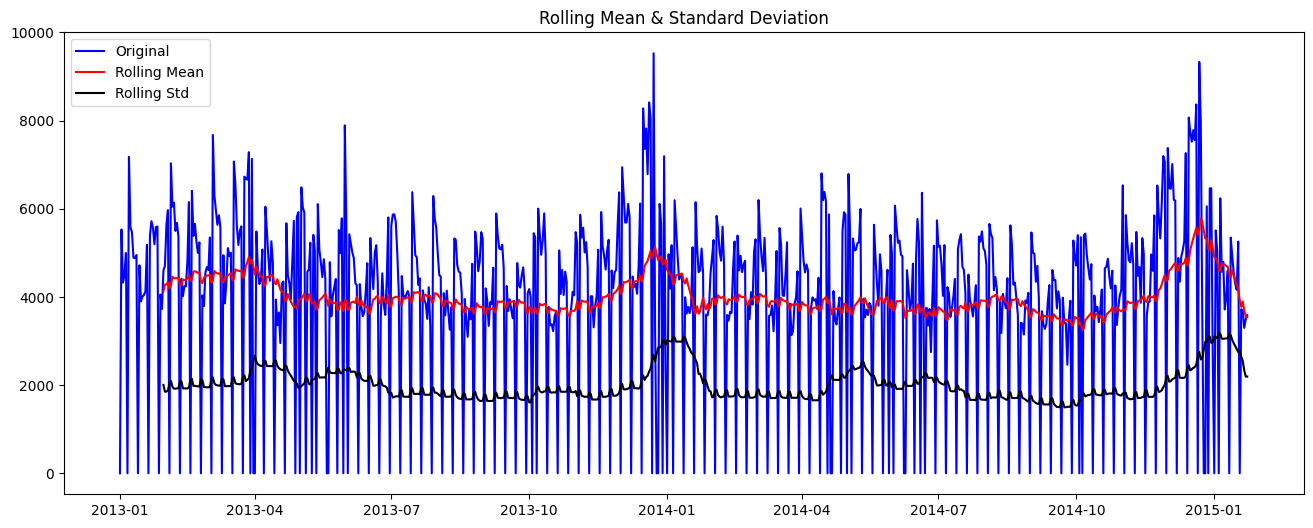

In [50]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

#Determing rolling statistics
rolmean = train_data[["Sales"]].rolling( window=30).mean()
rolstd = train_data[["Sales"]].rolling(window=30).std()

#Plot rolling statistics:
orig = axes.plot(train_data[["Sales"]], color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

### Check stationarity:

In [51]:
adf_test(train_data[["Sales"]])

ADF Statistic: -3.6278645835415726
p-value: 0.005250125104946595
Critical Values:
	1%: -3.439314999916068
	5%: -2.8654965012008677
	10%: -2.5688768817372867
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [52]:
kpss_test(train_data[["Sales"]])

KPSS Statistic: 0.2099586392870777
p-value: 0.1
Lags Used: 3
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


/tmp/ipykernel_34/3039272199.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




### <font color='green'>**In the first look, data seems to be non stationary. Despite that, the tests confirm that the data is stationary. The STD is high but is almost steady across all the winows**</font>

### Autocorrelatin Graphs

In [62]:
autocorrelation_graphs(train_data[["Sales"]], n_lags=40, title_text="Autocorrelatin Graphs of sales")

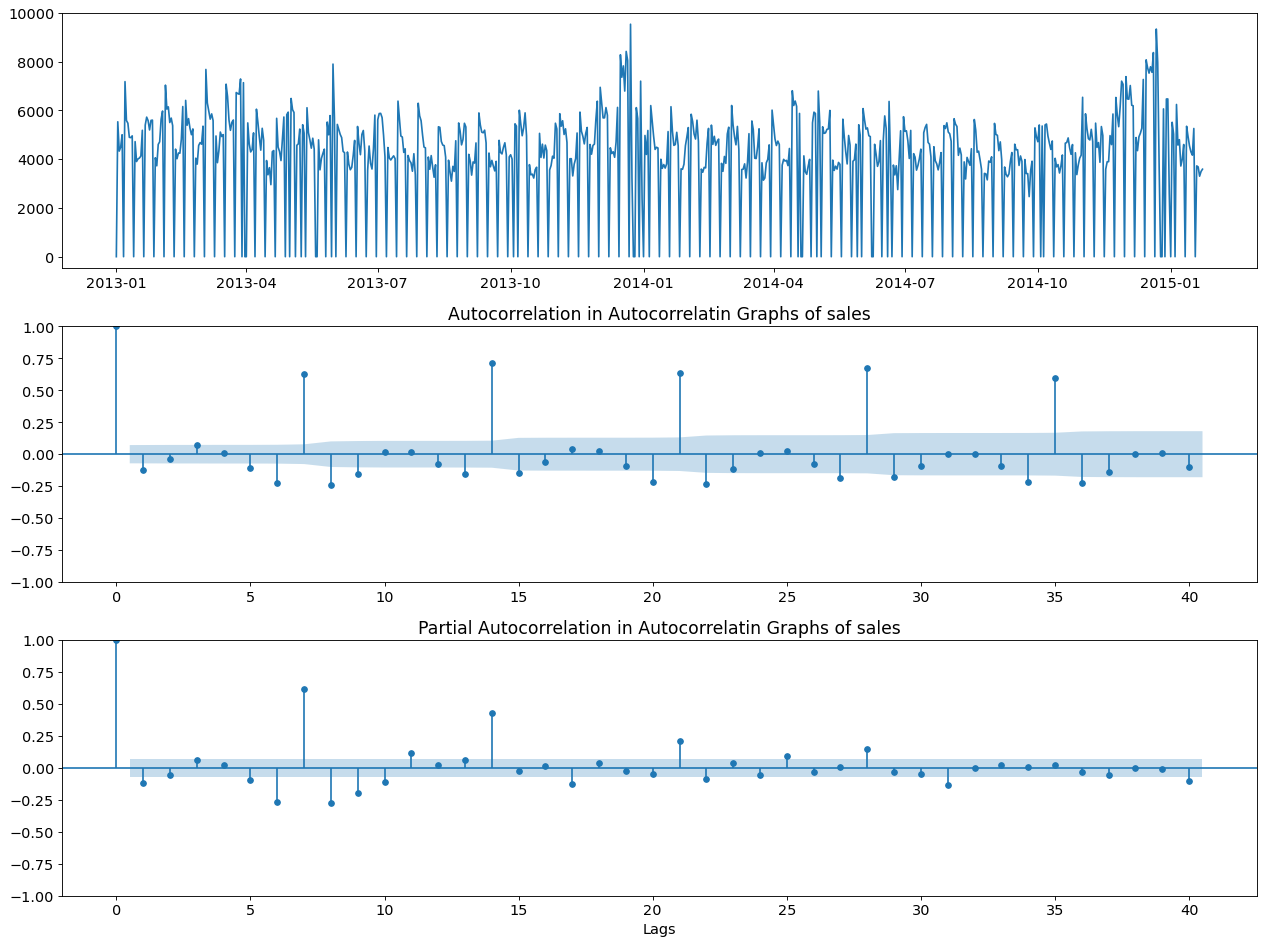

In [181]:
autocorrelatin_graphs(train_data[["Sales"]], n_lags=40, title_text="Autocorrelatin Graphs of sales")

### <font color='green'>**The ACF and PACF show a sine wave-like correlation pattern with high positive correlations at lag 7, 14, 21, and so on, it suggests the presence of a seasonal component in the data.**</font>

### Arima

In [63]:
# fit model
ARIMA_model = ARIMA(train_data[["Sales"]], order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

In [64]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  753
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6799.437
Date:                Fri, 07 Jun 2024   AIC                          13604.874
Time:                        18:32:04   BIC                          13618.742
Sample:                    01-01-2013   HQIC                         13610.217
                         - 01-23-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1163      0.035     -3.347      0.001      -0.184      -0.048
ma.L1         -0.9999      0.079    -12.730      0.000      -1.154      -0.846
sigma2      4.142e+06   3.15e+05     13.162      0.000    3.53e+06    4.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                75.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.77
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)

### Make Value of prediction = 0 when The Store is not open

In [66]:
arima_preds[test_data["Open"] == 0] = 0

### Evaluate performance

In [67]:
print(f'RMSPE for Arima on test:{rmspe(arima_preds,test_data[["Sales"]])}')

RMSPE for Arima on test:0.2707639706677056


In [69]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Train and Test Data with ARIMA Predictions', 'Test Data with ARIMA Predictions'))

fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=arima_preds.index, y=arima_preds, mode='lines', name='Arima', line=dict(color='red')), row=1, col=1)

fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=arima_preds.index, y=arima_preds, mode='lines', name='Arima', line=dict(color='red')), row=2, col=1)

fig.update_layout(
    height=600,
    width=1600,
    title='Sales Data and ARIMA Predictions',
    xaxis_title='Date',
    yaxis_title='Sales'
)

# Update y-axis titles
fig.update_yaxes(title_text='Sales', row=1, col=1)
fig.update_yaxes(title_text='Sales', row=2, col=1)

# Show plot
fig.show()


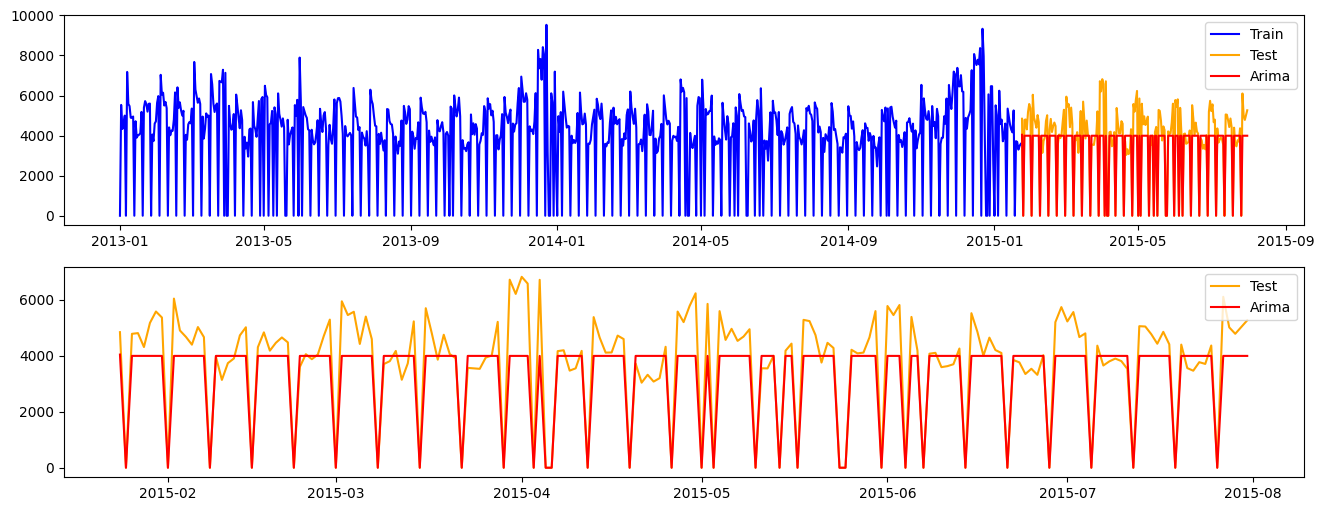

In [68]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(arima_preds,label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()

### SARIMAX

#### <font color='green'>**Considering the characteristics, an appropriate model to capture the seasonality and the sine wave-like patterns would be the SARIMA (Seasonal Autoregressive Integrated Moving Average) model. SARIMA is an extension of the ARIMA model that incorporates seasonal components.**</font>

In [70]:
# fit model
SARIMAX_model = SARIMAX(train_data[["Sales"]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
SARIMAX_model_fit = SARIMAX_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58464D+00    |proj g|=  6.16807D-02

At iterate    5    f=  8.54030D+00    |proj g|=  8.82730D-03

At iterate   10    f=  8.53659D+00    |proj g|=  5.96055D-04

At iterate   15    f=  8.53628D+00    |proj g|=  7.95878D-04

At iterate   20    f=  8.53576D+00    |proj g|=  1.25737D-02

At iterate   25    f=  8.48374D+00    |proj g|=  1.70057D-01

At iterate   30    f=  8.41236D+00    |proj g|=  1.70599D-02

At iterate   35    f=  8.40709D+00    |proj g|=  6.55906D-03

At iterate   40    f=  8.40667D+00    |proj g|=  1.82679D-03

At iterate   45    f=  8.40653D+00    |proj g|=  3.41785D-04

At iterate   50    f=  8.40653D+00    |proj g|=  2.49977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [71]:
SARIMAX_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  753
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6330.116
Date:                           Fri, 07 Jun 2024   AIC                          12670.232
Time:                                   18:33:54   BIC                          12693.299
Sample:                               01-01-2013   HQIC                         12679.123
                                    - 01-23-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2126      0.020     10.846      0.000       0.174       0.251
ma.L1         -0.9482      0.010    -97.632      0.000      -0.967      -0.929
ar.S.L7       -0.0742      0.028     -2.628      0.009      -0.129      -0.019
ma.S.L7       -0.9982      0.180     -5.549      0.000      -1.351      -0.646
sigma2      1.339e+06   2.28e+05      5.884      0.000    8.93e+05    1.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1580.73
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.43
Prob(H) (two-sided):                  0.97   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)

### Make Value of prediction = 0 when The Store is not open

In [73]:
SARIMAX_preds[test_data["Open"] == 0] = 0

In [74]:
print(f'RMSPE for SARIMAX on test:{rmspe(SARIMAX_preds,test_data[["Sales"]])}')

RMSPE for SARIMAX on test:0.1948757340084279


In [75]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Train and Test Data with SARIMAX Predictions', 'Test Data with SARIMAX Predictions'))

# Add traces for the first subplot
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=SARIMAX_preds.index, y=SARIMAX_preds, mode='lines', name='SARIMAX', line=dict(color='red')), row=1, col=1)

# Add traces for the second subplot
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=SARIMAX_preds.index, y=SARIMAX_preds, mode='lines', name='SARIMAX', line=dict(color='red')), row=2, col=1)

# Update layout
fig.update_layout(
    height=600,
    width=1600,
    title='Sales Data and SARIMAX Predictions',
    xaxis_title='Date',
    yaxis_title='Sales'
)

# Update y-axis titles
fig.update_yaxes(title_text='Sales', row=1, col=1)
fig.update_yaxes(title_text='Sales', row=2, col=1)

# Show plot
fig.show()


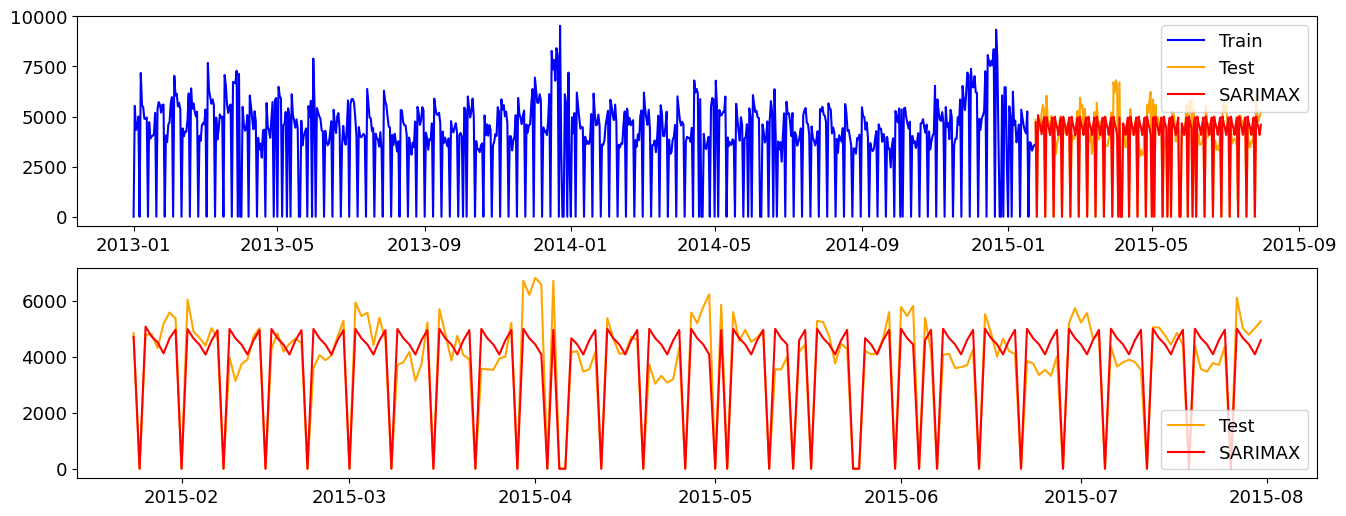

In [445]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[1].legend(loc='best')
plt.show()

### Auto Arima

In [76]:
stepwise_model = auto_arima(train_data[["Sales"]],start_p=1, start_q=1,d=1, max_p=3, max_q=3,
                            seasonal=True, start_P =1, start_Q=1, D=1, max_Q=3, max_P=3, max_order=12, m=7,
                            trace=True,stationary=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13621.052, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13483.023, Time=1.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13446.503, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14803.470, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=13611.017, Time=0.24 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=13269.196, Time=1.38 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=13266.485, Time=2.82 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=13215.178, Time=3.49 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(0,0,1)(3,0,2)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(2,0,3)[7] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(0,0,1)(1,0,3)[7] intercept   : AIC=13194.781, Time=4.89 sec
 ARIMA(0,0,1)(0,0,3)[7] intercept   : AIC=13199.21

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  753
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -6547.614
Date:                                   Fri, 07 Jun 2024   AIC                          13111.228
Time:                                           18:37:12   BIC                          13148.221
Sample:                                       01-01-2013   HQIC                         13125.480
                                            - 01-23-2015                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4312.6531    530.694      8.126      0.000    3272.513    5352.794
ar.L1         -0.9462      0.017    -55.801      0.000      -0.979      -0.913
ma.L1          0.9870      0.007    131.754      0.000       0.972       1.002
ar.S.L7        0.4955      0.063      7.868      0.000       0.372       0.619
ma.S.L7       -0.2063      0.068     -3.040      0.002      -0.339      -0.073
ma.S.L14       0.3463      0.030     11.378      0.000       0.287       0.406
ma.S.L21       0.1660      0.045      3.725      0.000       0.079       0.253
sigma2      1.881e+06   7.29e+04     25.801      0.000    1.74e+06    2.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.45   Jarque-Bera (JB):                95.03
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.43
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
length = len(test_data)

#Predictions
auto_arima_forecast,conf_int = stepwise_model.predict(n_periods=length,return_conf_int=True)

### Make Value of prediction = 0 when The Store is not open

In [78]:
auto_arima_forecast[test_data["Open"] == 0] = 0

In [79]:
print(f'RMSPE for Auto Arima on test:{rmspe(auto_arima_forecast,test_data[["Sales"]])}')

RMSPE for Auto Arima on test:0.21417501068559106


In [80]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Train and Test Data with Auto ARIMA Forecast', 'Test Data with Auto ARIMA Forecast'))

# Add traces for the first subplot
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=auto_arima_forecast.index, y=auto_arima_forecast, mode='lines', name='Auto Arima', line=dict(color='red')), row=1, col=1)

# Add traces for the second subplot
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=auto_arima_forecast.index, y=auto_arima_forecast, mode='lines', name='Auto Arima', line=dict(color='red')), row=2, col=1)

# Update layout
fig.update_layout(
    height=600,
    width=1600,
    title='Sales Data and Auto ARIMA Forecast',
    xaxis_title='Date',
    yaxis_title='Sales'
)

# Update y-axis titles
fig.update_yaxes(title_text='Sales', row=1, col=1)
fig.update_yaxes(title_text='Sales', row=2, col=1)

# Show plot
fig.show()


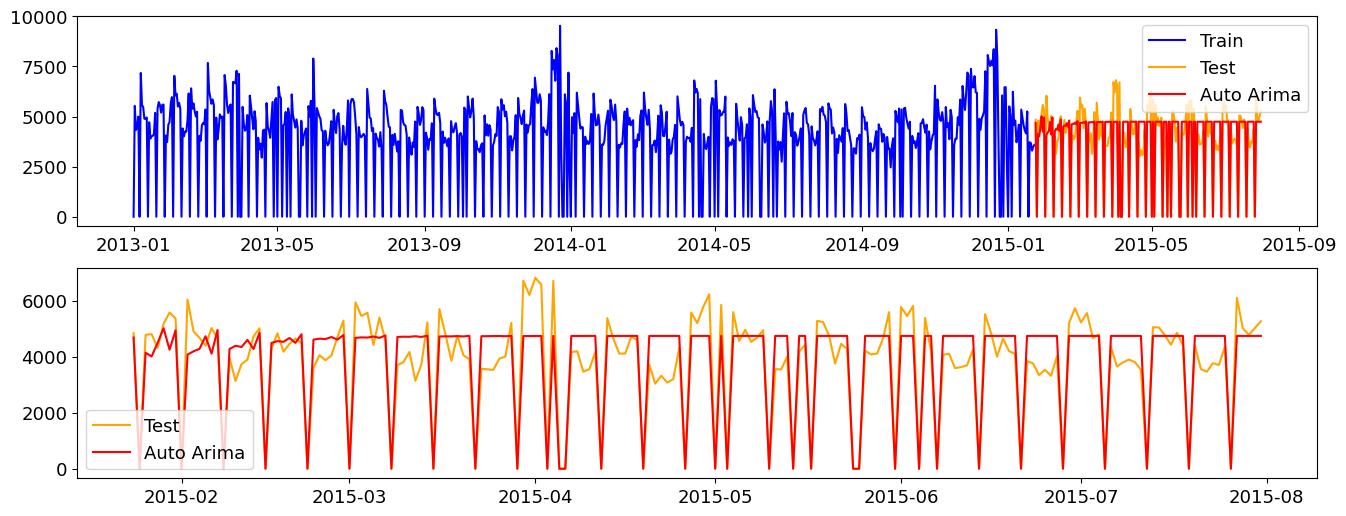

In [420]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(auto_arima_forecast,label="Auto Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(auto_arima_forecast,label="Auto Arima",color='red')
axes[1].legend(loc='best')
plt.show()

## **D- Prophet**

### Define preparing data function

In [81]:
def prepare_df_prophet(df, Type="train"):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    new_df = new_df.reset_index()
    new_df.rename({"Sales": "y", "Date" : "ds"},axis=1, inplace = True)
    if Type == "test":
        new_df.drop("y", axis=1, inplace=True)
    return new_df

In [82]:
train_prophet = prepare_df_prophet(train_data)

In [83]:
train_prophet.columns

Index(['ds', 'DayOfWeek', 'y', 'Open', 'Promo', 'SchoolHoliday', 'year',
       'month', 'day', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear'],
      dtype='object')

### Create model instance and adding all features as regressors

In [84]:
Prophet_model = Prophet()

regressors = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'DayOfYear', 'WeekOfYear']

for regressor in regressors:
    Prophet_model.add_regressor(regressor)

### Model fitting

In [85]:
Prophet_model.fit(train_prophet)

18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing


### Prepare test dataset

In [86]:
test_prophet = prepare_df_prophet(test_data, Type="test")

In [87]:
forecast = Prophet_model.predict(test_prophet)

In [88]:
prophet_preds = forecast.copy(deep=True)
prophet_preds = prophet_preds.set_index("ds")["yhat"].clip(lower=0)

### Make Value of prediction = 0 when The Store is not open

In [89]:
prophet_preds[test_data["Open"] == 0] = 0

### Evaluate performance

In [90]:
print(f'RMSPE for Prophet on Test:{rmspe(prophet_preds,test_data["Sales"])}')

RMSPE for Prophet on Test:0.14125369421456863


### Plot predictions

In [91]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Train and Test Data with Prophet Forecast', 'Test Data with Prophet Forecast'))

fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=prophet_preds.index, y=prophet_preds, mode='lines', name='Prophet', line=dict(color='red')), row=1, col=1)

fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=prophet_preds.index, y=prophet_preds, mode='lines', name='Prophet', line=dict(color='red')), row=2, col=1)

fig.update_layout(
    height=600,
    width=1600,
    title='Sales Data and Prophet Forecast',
    xaxis_title='Date',
    yaxis_title='Sales'
)

fig.update_yaxes(title_text='Sales', row=1, col=1)
fig.update_yaxes(title_text='Sales', row=2, col=1)

fig.show()

---

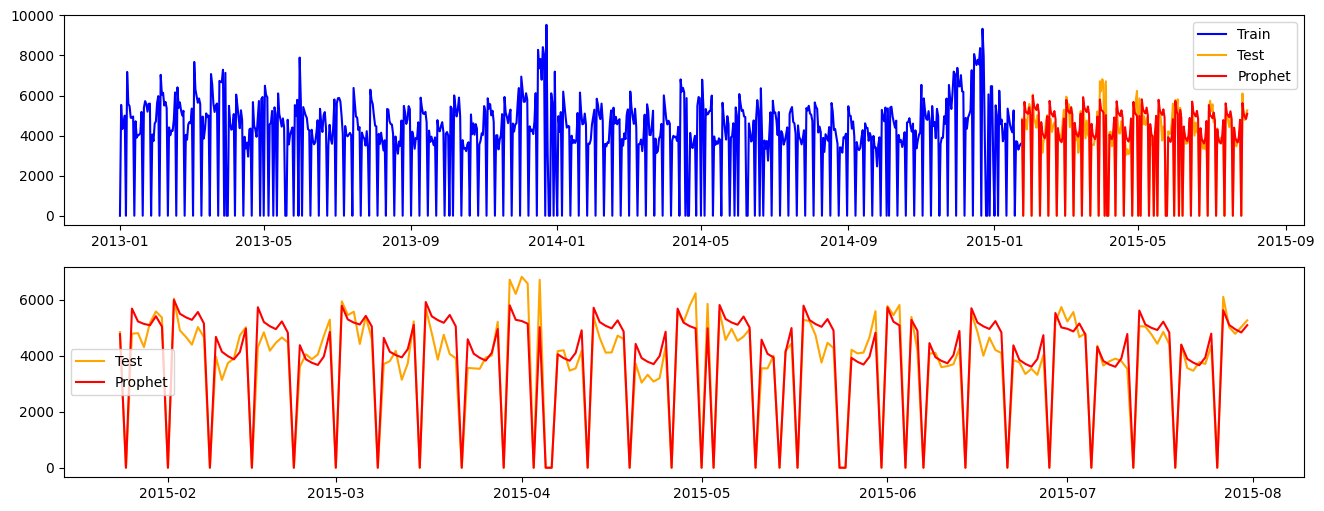

In [92]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(prophet_preds,label="Prophet",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(prophet_preds,label="Prophet",color='red')
axes[1].legend(loc='best')
plt.show()

# 7. <a name="7">**Machine Learning model**</a>
(<a href="#0">Go to top</a>)

In [94]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

### Prepare df function

In [95]:
def prepare_df_ml(df):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    df_prep_X = new_df.drop("Sales", axis=1)
    df_prep_Y = new_df["Sales"]
    return df_prep_X, df_prep_Y

### Prepare training data

In [96]:
train_prep_X, train_prep_Y = prepare_df_ml(train_data)

In [97]:
train_prep_X.head()

DayOfWeek  Open  Promo  SchoolHoliday  Day  Month  Year  \
Date                                                                  
2013-01-01          2     0      0              1    1      1  2013   
2013-01-02          3     1      0              1    2      1  2013   
2013-01-03          4     1      0              1    3      1  2013   
2013-01-04          5     1      0              1    4      1  2013   
2013-01-05          6     1      0              1    5      1  2013   

            DayOfYear  WeekOfYear  
Date                               
2013-01-01          1           1  
2013-01-02          2           1  
2013-01-03          3           1  
2013-01-04          4           1  
2013-01-05          5           1

In [98]:
train_prep_Y

Date
2013-01-01       0
2013-01-02    5530
2013-01-03    4327
2013-01-04    4486
2013-01-05    4997
              ... 
2015-01-19    3721
2015-01-20    3680
2015-01-21    3299
2015-01-22    3492
2015-01-23    3586
Freq: D, Name: Sales, Length: 753, dtype: int64

### Model fitting

In [99]:
lgbm_model = LGBMRegressor(random_state=42, max_depth=50)

In [100]:
train_prep_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Freq: D
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   DayOfWeek      753 non-null    int64
 1   Open           753 non-null    int64
 2   Promo          753 non-null    int64
 3   SchoolHoliday  753 non-null    int64
 4   Day            753 non-null    int64
 5   Month          753 non-null    int64
 6   Year           753 non-null    int64
 7   DayOfYear      753 non-null    int64
 8   WeekOfYear     753 non-null    int64
dtypes: int64(9)
memory usage: 58.8 KB


In [101]:
lgbm_model.fit(train_prep_X, train_prep_Y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

LGBMRegressor(max_depth=50, random_state=42)

### Performance on train

In [102]:
lgbm_train_preds = lgbm_model.predict(train_prep_X)
lgbm_train_preds = pd.Series(lgbm_train_preds, index= train_prep_X.index)
lgbm_train_preds = lgbm_train_preds.clip(lower=0)
lgbm_train_preds[train_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Train:{rmspe(lgbm_train_preds,train_prep_Y)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSPE for LGBM on Train:0.07557671067339185


### Prepare testing data

In [103]:
test_prep_X, test_prep_Y = prepare_df_ml(test_data)

In [104]:
test_prep_X

DayOfWeek  Open  Promo  SchoolHoliday  Day  Month  Year  \
Date                                                                  
2015-01-24          6     1      0              0   24      1  2015   
2015-01-25          7     0      0              0   25      1  2015   
2015-01-26          1     1      1              0   26      1  2015   
2015-01-27          2     1      1              0   27      1  2015   
2015-01-28          3     1      1              0   28      1  2015   
...               ...   ...    ...            ...  ...    ...   ...   
2015-07-27          1     1      1              1   27      7  2015   
2015-07-28          2     1      1              1   28      7  2015   
2015-07-29          3     1      1              1   29      7  2015   
2015-07-30          4     1      1              1   30      7  2015   
2015-07-31          5     1      1              1   31      7  2015   

            DayOfYear  WeekOfYear  
Date                               
2015-01-24         24           4  
2015-01-25         25           4  
2015-01-26         26           5  
2015-01-27         27           5  
2015-01-28         28           5  
...               ...         ...  
2015-07-27        208          31  
2015-07-28        209          31  
2015-07-29        210          31  
2015-07-30        211          31  
2015-07-31        212          31  

[189 rows x 9 columns]

In [105]:
lgbm_preds = lgbm_model.predict(test_prep_X)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### Performance on test

In [106]:
lgbm_test_preds = lgbm_model.predict(test_prep_X)
lgbm_test_preds = pd.Series(lgbm_test_preds, index= test_prep_X.index)
lgbm_test_preds = lgbm_test_preds.clip(lower=0)
lgbm_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Test:{rmspe(lgbm_test_preds,test_prep_Y)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSPE for LGBM on Test:0.1080306113018498


### Plot predictions

In [113]:

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add traces for the first subplot
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=lgbm_test_preds, mode='lines', name='LGBM', line=dict(color='red')), row=1, col=1)

# Add traces for the second subplot
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=lgbm_test_preds, mode='lines', name='LGBM', line=dict(color='red')), row=2, col=1)

# Update layout
fig.update_layout(height=600, width=1600, title_text="Sales Data and LGBM Predictions")

# Show plot
fig.show()


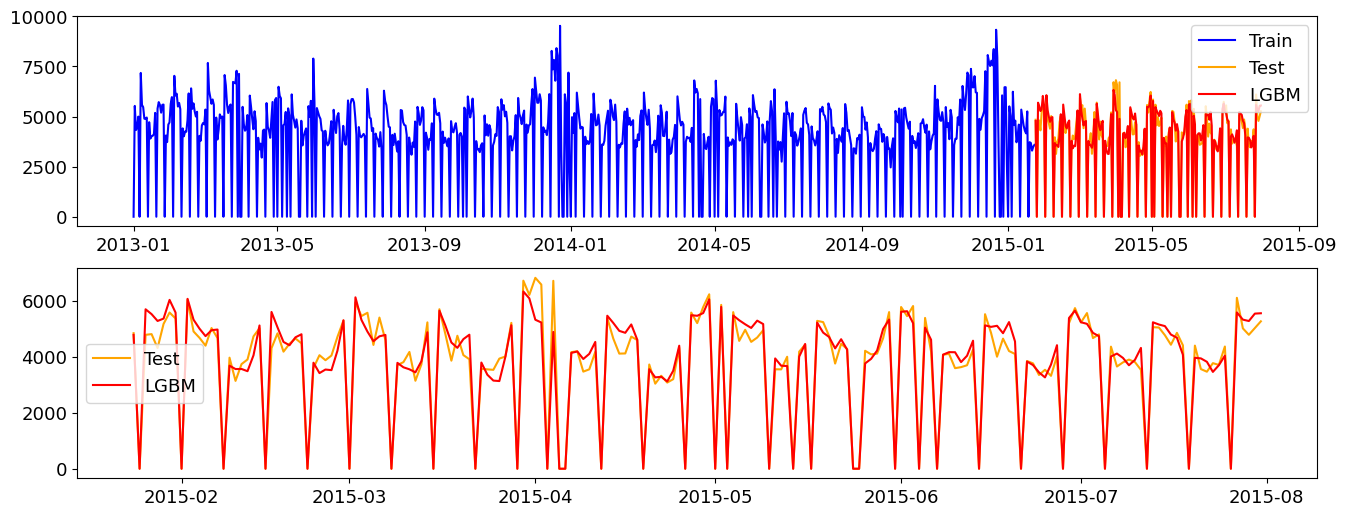

In [290]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(lgbm_test_preds,label="LGBM",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(lgbm_test_preds,label="LGBM",color='red')
axes[1].legend(loc='best')
plt.show()

### Fine Tuning

In [114]:
# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1],  # Learning rate for boosting
    'n_estimators': [100, 200, 300],  # Number of boosting iterations
    'reg_alpha': [0.0, 0.1, 0.5],  # L1 regularization term on weights
    'reg_lambda': [0.0, 0.1, 0.5],  # L2 regularization term on weights
    'max_depth': [-1, 5, 10],  # Maximum depth of a tree
}

# Generate all possible combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

# Create lists to store the results
best_params = None
best_model = None
best_rmspe = float('inf')

# Iterate over each parameter combination
for params in tqdm(param_combinations):
    # Create the LGBMRegressor model with the current hyperparameters
    lgbm_model = LGBMRegressor(random_state=42, **dict(zip(param_grid.keys(), params)))
    
    # Fit the model to the training data
    lgbm_model.fit(train_prep_X, train_prep_Y)
    
    # Make predictions on the test data
    lgbm_test_preds = lgbm_model.predict(test_prep_X)
    lgbm_test_preds = pd.Series(lgbm_test_preds, index=test_prep_X.index)
    lgbm_test_preds = lgbm_test_preds.clip(lower=0)
    lgbm_test_preds[test_prep_X["Open"] == 0] = 0
    # Calculate RMSPE
    rmspe_value = rmspe(lgbm_test_preds, test_prep_Y)
    
    # Check if the current model has the best RMSPE
    if rmspe_value < best_rmspe:
        best_rmspe = rmspe_value
        print(f"  Found new best RMSPE: {best_rmspe}")
        best_params = params
        best_model = lgbm_model

# Print the best hyperparameters and RMSPE
print(f"Best Parameters: {dict(zip(param_grid.keys(), best_params))}")
print(f"RMSPE for Best LGBM on Test: {best_rmspe}")

  2%|▏         | 3/162 [00:00<00:07, 21.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

  6%|▌         | 9/162 [00:00<00:06, 22.42it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  7%|▋         | 12/162 [00:00<00:06, 21.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

  9%|▉         | 15/162 [00:00<00:06, 21.62it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 13%|█▎        | 21/162 [00:00<00:06, 21.57it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accu

 15%|█▍        | 24/162 [00:01<00:06, 21.62it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 17%|█▋        | 27/162 [00:01<00:06, 21.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 19%|█▊        | 30/162 [00:01<00:07, 17.04it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 20%|█▉        | 32/162 [00:01<00:08, 15.72it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 22%|██▏       | 36/162 [00:02<00:09, 13.51it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 23%|██▎       | 38/162 [00:02<00:09, 13.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 25%|██▍       | 40/162 [00:02<00:10, 11.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 26%|██▌       | 42/162 [00:02<00:09, 12.06it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 27%|██▋       | 44/162 [00:02<00:09, 12.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

 28%|██▊       | 46/162 [00:02<00:10, 11.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 30%|██▉       | 48/162 [00:03<00:09, 11.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 32%|███▏      | 52/162 [00:03<00:09, 11.26it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

 33%|███▎      | 54/162 [00:03<00:09, 11.70it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 35%|███▍      | 56/162 [00:03<00:10, 10.50it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 36%|███▌      | 58/162 [00:04<00:11,  9.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 37%|███▋      | 60/162 [00:04<00:11,  8.97it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 38%|███▊      | 61/162 [00:04<00:11,  8.50it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 39%|███▉      | 63/162 [00:04<00:11,  8.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 40%|███▉      | 64/162 [00:04<00:11,  8.22it/s]

  Found new best RMSPE: 0.11220240170399404
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

 41%|████▏     | 67/162 [00:05<00:12,  7.82it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 43%|████▎     | 69/162 [00:05<00:11,  7.90it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 43%|████▎     | 70/162 [00:05<00:12,  7.37it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

 45%|████▌     | 73/162 [00:06<00:11,  7.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 47%|████▋     | 76/162 [00:06<00:11,  7.49it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

 49%|████▉     | 79/162 [00:06<00:11,  7.46it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

 50%|█████     | 81/162 [00:07<00:10,  7.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 52%|█████▏    | 84/162 [00:07<00:07, 10.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 54%|█████▎    | 87/162 [00:07<00:05, 13.31it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 57%|█████▋    | 93/162 [00:07<00:04, 16.32it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

 60%|█████▉    | 97/162 [00:07<00:03, 17.04it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 62%|██████▏   | 100/162 [00:08<00:03, 18.08it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 64%|██████▎   | 103/162 [00:08<00:03, 18.79it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 65%|██████▌   | 106/162 [00:08<00:02, 19.34it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 69%|██████▊   | 111/162 [00:08<00:03, 16.48it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

 70%|██████▉   | 113/162 [00:08<00:03, 14.91it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 71%|███████   | 115/162 [00:09<00:03, 12.80it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 72%|███████▏  | 117/162 [00:09<00:03, 12.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 73%|███████▎  | 119/162 [00:09<00:03, 12.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 75%|███████▍  | 121/162 [00:09<00:03, 11.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 76%|███████▌  | 123/162 [00:09<00:03, 10.90it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 77%|███████▋  | 125/162 [00:10<00:03, 10.97it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 78%|███████▊  | 127/162 [00:10<00:03, 10.36it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 80%|███████▉  | 129/162 [00:10<00:03, 10.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 81%|████████  | 131/162 [00:10<00:02, 11.13it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 82%|████████▏ | 133/162 [00:10<00:02, 10.30it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 83%|████████▎ | 135/162 [00:10<00:02, 10.58it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 85%|████████▍ | 137/162 [00:11<00:02,  9.66it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

 86%|████████▌ | 139/162 [00:11<00:02,  8.08it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

 88%|████████▊ | 142/162 [00:11<00:02,  7.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 89%|████████▉ | 144/162 [00:12<00:02,  8.06it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 90%|████████▉ | 145/162 [00:12<00:02,  7.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 91%|█████████ | 147/162 [00:12<00:01,  8.00it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 91%|█████████▏| 148/162 [00:12<00:01,  7.38it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 93%|█████████▎| 150/162 [00:12<00:01,  7.86it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 93%|█████████▎| 151/162 [00:13<00:01,  7.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 94%|█████████▍| 153/162 [00:13<00:01,  7.78it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 95%|█████████▌| 154/162 [00:13<00:01,  7.17it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 96%|█████████▋| 156/162 [00:13<00:00,  7.69it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 97%|█████████▋| 157/162 [00:13<00:00,  7.13it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 98%|█████████▊| 159/162 [00:14<00:00,  7.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 99%|█████████▉| 160/162 [00:14<00:00,  7.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 162/162 [00:14<00:00, 11.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Performance of best model

In [115]:
lgbm_test_preds = best_model.predict(test_prep_X)
lgbm_test_preds = pd.Series(lgbm_test_preds, index= test_prep_X.index)
lgbm_test_preds = lgbm_test_preds.clip(lower=0)
lgbm_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Test:{rmspe(lgbm_test_preds,test_prep_Y)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSPE for LGBM on Test:0.10394196981842323


### Plot predictions of best model

In [116]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add traces to the first subplot (Train, Test, LGBM)
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=lgbm_test_preds, mode='lines', name='LGBM', line=dict(color='red')), row=1, col=1)

# Add traces to the second subplot (Test, LGBM)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=lgbm_test_preds, mode='lines', name='LGBM', line=dict(color='red')), row=2, col=1)

# Update layout to set figure size and title
fig.update_layout(
    height=600, 
    width=1600, 
    title_text="Sales Data and LGBM Predictions",
    legend_title_text='Legend'
)

# Show plot
fig.show()


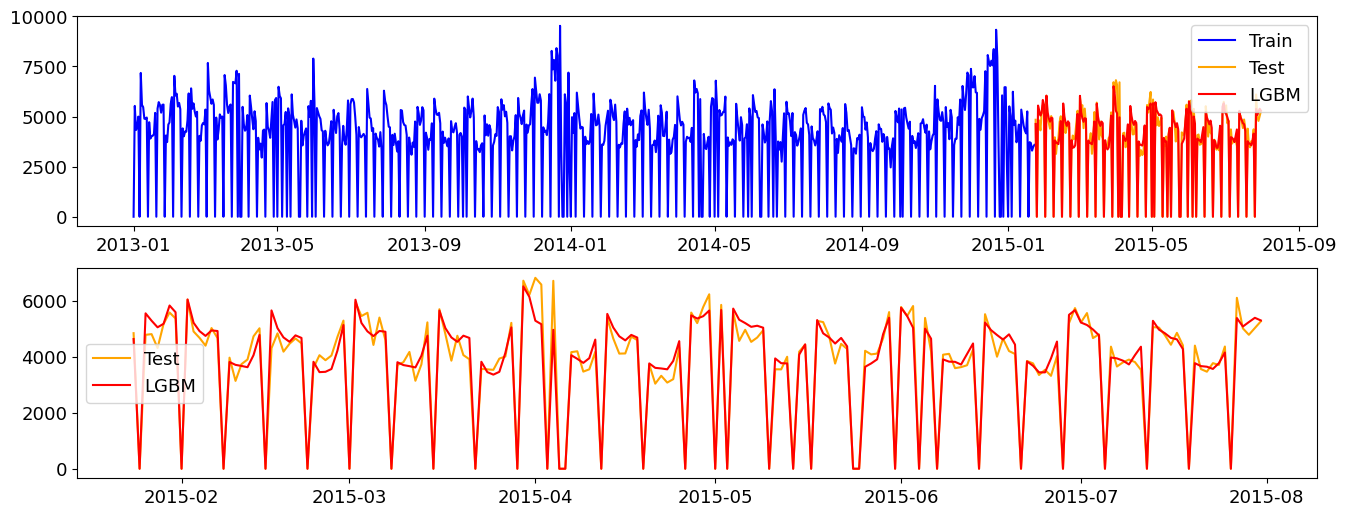

In [293]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(lgbm_test_preds,label="LGBM",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(lgbm_test_preds,label="LGBM",color='red')
axes[1].legend(loc='best')
plt.show()

Voting Classifier

## Voting 

In [119]:
lgbm_model = LGBMRegressor(random_state=42, max_depth=50)
xgb_model = XGBRegressor(random_state=42, max_depth=50)
cat_model = CatBoostRegressor(random_state=42, depth=10, silent=True)

# Train the models
lgbm_model.fit(train_prep_X, train_prep_Y)
xgb_model.fit(train_prep_X, train_prep_Y)
cat_model.fit(train_prep_X, train_prep_Y)

# Combine the models using a voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('cat', cat_model)
    ]
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [120]:
# Fit the voting regressor
voting_model.fit(train_prep_X, train_prep_Y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 9
[LightGBM] [Info] Start training from score 3996.416999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(max_depth=50, random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=50,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x7eddddbba110>)])

In [121]:
# Make predictions on the test set
voting_preds = voting_model.predict(test_prep_X)
voting_preds = pd.Series(voting_preds, index=test_prep_X.index)
voting_preds = voting_preds.clip(lower=0)
voting_preds[test_prep_X["Open"] == 0] = 0

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [122]:
# Calculate RMSPE for the ensemble model
rmspe_ensemble = rmspe(test_prep_Y, voting_preds)
print(f'RMSPE for Voting Ensemble on Test: {rmspe_ensemble}')

RMSPE for Voting Ensemble on Test: 0.11249652506200812


### Plot predictions

In [123]:
# Plot the results with Plotly
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add traces to the first subplot (Train, Test, Voting Ensemble)
fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], mode='lines', name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=voting_preds, mode='lines', name='Voting Ensemble', line=dict(color='red')), row=1, col=1)

# Add traces to the second subplot (Test, Voting Ensemble)
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], mode='lines', name='Test', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_data.index, y=voting_preds, mode='lines', name='Voting Ensemble', line=dict(color='red')), row=2, col=1)

# Update layout to set figure size and title
fig.update_layout(
    height=600,
    width=1600,
    title_text="Sales Data and Voting Ensemble Predictions",
    legend_title_text='Legend'
)

# Show plot
fig.show()

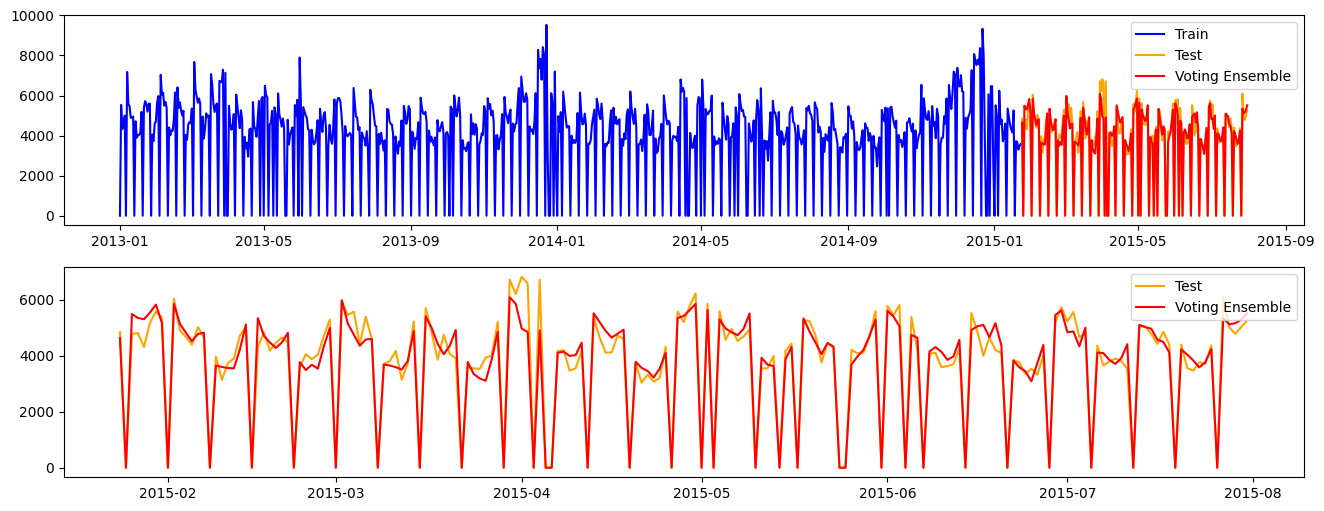

In [124]:
# Matplotlib Plot for comparison
fig, axes = plt.subplots(2, 1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train', color='blue')
axes[0].plot(test_data["Sales"], label='Test', color='orange')
axes[0].plot(voting_preds, label='Voting Ensemble', color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test', color='orange')
axes[1].plot(voting_preds, label='Voting Ensemble', color='red')
axes[1].legend(loc='best')

plt.show()

## ETS Forecast

In [128]:
# Fit the ETS model (Triple Exponential Smoothing, if trend and seasonality are expected)
ets_model = ExponentialSmoothing(train_data["Sales"], trend='add', seasonal='add', seasonal_periods=12)
ets_fitted_model = ets_model.fit()

# Forecast for the test period
ets_forecast = ets_fitted_model.forecast(steps=len(test_data))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [129]:
# Evaluate ETS Model
rmspe_ets = rmspe(test_data["Sales"], ets_forecast)
print(f'RMSPE for ETS Model: {rmspe_ets}')

RMSPE for ETS Model: 0.5183054702638102


In [131]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=train_data.index, y=train_data["Sales"], 
                         mode='lines', name='Train', line=dict(color='blue')))

# Add the test data trace
fig.add_trace(go.Scatter(x=test_data.index, y=test_data["Sales"], 
                         mode='lines', name='Test', line=dict(color='orange')))

# Add the ETS forecast trace
fig.add_trace(go.Scatter(x=test_data.index, y=ets_forecast, 
                         mode='lines', name='ETS Forecast', line=dict(color='red', dash='dash')))

# Update layout for the figure
fig.update_layout(
    height=600,
    width=1200,
    title='ETS Forecast vs Actual Sales',
    xaxis_title='Date',
    yaxis_title='Sales',
    legend_title='Legend',
    template='plotly_white'
)

# Show plot
fig.show()

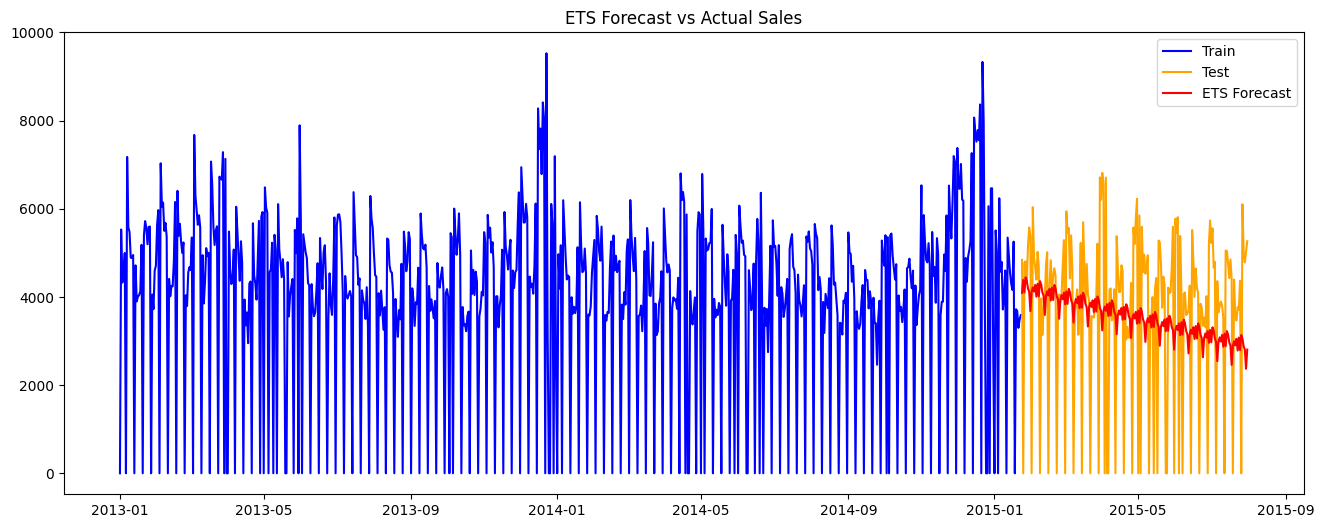

In [132]:
# Plot the ETS Forecast
plt.figure(figsize=(16, 6))
plt.plot(train_data.index, train_data["Sales"], label='Train', color='blue')
plt.plot(test_data.index, test_data["Sales"], label='Test', color='orange')
plt.plot(test_data.index, ets_forecast, label='ETS Forecast', color='red')
plt.legend(loc='best')
plt.title('ETS Forecast vs Actual Sales')
plt.show()

---

# 8. <a name="8">**Choosing Best Model**</a>
(<a href="#0">Go to top</a>)

| Method                        | RMSPE                    | Model Type      |
|-------------------------------|-------------------------|------------------|
| **LGBM**                      | **0.1039**              | **ML**           |
| **Voting**                    | **0.1124**              | **ML**           |
| Prophet                       | 0.1412                  | Time Series      |
| SARIMAX                       | 0.1947                  | Time Series      |
| Auto Arima                    | 0.1999                  | Time Series      |
| average method                | 0.2700                  | Simple Model     |
| Arima                         | 0.2707                  | Time Series      |
| Seasonal Naive method         | 0.2785                  | Simple Model     |
| Naive method                  | 0.3849                  | Simple Model     |
| Drift method                  | 0.4765                  | Simple Model     |
| ETS model trend               | 0.5183                  | Seasonal Model     |


## Summary

**The LGBM model ,Voting model outperformed other models in the competition, indicating that the provided features have significant predictive power for sales forecasting. The time series models, including Prophet, SARIMAX and Auto ARIMA, performed reasonably well but were less accurate than the LGBM model , Voting model. The simple models, such as the average method and the Seasonal Naive method, provided baseline performance, while the Naive method, and Drift method showed relatively higher errors, suggesting limitations in capturing the complexities of the sales data.**

## **Best model: LGBM Regressor**

**The best-performing model in terms of RMSPE (Root Mean Square Percentage Error) is the LightGBM (LGBM) model, with an RMSPE of 0.1039. LGBM is a gradient boosting framework that uses decision trees as base learners. Its strong performance suggests that the features provided in the dataset have significant predictive power, and the LGBM model effectively captures the relationships between these features and the sales data.**

## **Best model: Voting Regressor**

**The best-performing model in terms of RMSPE (Root Mean Square Percentage Error) is the voting (XGBOOST ,LGBM , CAT) model, with an RMSPE of 0.1124. Voting is a gradient boosting framework that uses decision trees as base learners. Its strong performance suggests that the features provided in the dataset have significant predictive power, and the Voting model effectively captures the relationships between these features and the sales data.**

## **Second Best model: Prophet**

**The second-best model is Prophet, a time series forecasting model developed by Facebook, with an RMSPE of 0.1366. Prophet is known for its ability to handle various time series patterns such as seasonality, trends, and holidays. Its slightly higher error compared to LGBM may be due to the nature of the data, where the predictive features utilized by LGBM might be better suited for capturing the sales patterns.**

---